<a href="https://colab.research.google.com/github/FatmaBuseBorlu/DRAMER-Dataset/blob/main/LSTM.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, confusion_matrix, f1_score
import matplotlib.pyplot as plt
import seaborn as sns
from torcheeg.datasets import DREAMERDataset
from torcheeg import transforms
from collections import Counter
import random

In [3]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
# Veri setinin bulunduğu dizin
dataset_path = "/content/drive/MyDrive/Dramer/Kodlar/DREAMER.mat"

In [5]:
# Veri Artırma: Gürültü ve Dönüşüm
class CustomRandomFlip:
    def __init__(self, axis):
        self.axis = axis

    def __call__(self, eeg=None, **kwargs):
        if eeg is not None and isinstance(eeg, torch.Tensor):
            if random.random() > 0.5:
                eeg = torch.flip(eeg, dims=(self.axis,))
        return {**kwargs, 'eeg': eeg}

offline_transform = transforms.Compose([
    transforms.BaselineRemoval(),
    transforms.MeanStdNormalize(),
    transforms.To2d(),
    transforms.ToTensor(),
    CustomRandomFlip(axis=2),
    transforms.RandomNoise(std=0.02)
])

# Veri Seti
dataset = DREAMERDataset(
    io_path='./dreamer_lstm_data',
    mat_path=dataset_path,
    offline_transform=offline_transform,
    label_transform=transforms.Compose([
        transforms.Select(['valence', 'arousal']),
        transforms.Binary(3.0)
    ]),
    chunk_size=128,
    baseline_chunk_size=128,
    num_baseline=61,
    num_worker=4
)

[2024-12-27 18:02:30] INFO (torcheeg/MainThread) 🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_lstm_data.
INFO:torcheeg:🔍 | Processing EEG data. Processed EEG data has been cached to ./dreamer_lstm_data.
[2024-12-27 18:02:30] INFO (torcheeg/MainThread) ⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
INFO:torcheeg:⏳ | Monitoring the detailed processing of a record for debugging. The processing of other records will only be reported in percentage to keep it clean.
[PROCESS]:  52%|█████▏    | 12/23 [02:50<02:58, 16.19s/it]/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
[PROCESS]: 100%|██████████| 23/23 [05:34<00:00, 14.55s/it]
[2024-12-27 18:11:09] INFO (torcheeg/

In [6]:
# Eğitim ve Test Veri Setleri
data_size = len(dataset)
train_size = int(0.8 * data_size)
test_size = data_size - train_size
train_dataset, test_dataset = random_split(dataset, [train_size, test_size])

In [7]:
# Veri yükleyiciler
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

In [18]:
# **Model Tanımlama**
class LSTMModel(nn.Module):
    def __init__(self, input_size=128, hidden_size=128, num_layers=2, num_classes=2, dropout_rate=0.3):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout_rate)
        self.fc_valence = nn.Linear(hidden_size, num_classes)
        self.fc_arousal = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        x = x.squeeze(1)  # 4D -> 3D dönüşüm
        out, _ = self.lstm(x)  # LSTM çıktısı
        out = out[:, -1, :]  # Sadece son zaman adımını alıyoruz
        valence_output = self.fc_valence(out)
        arousal_output = self.fc_arousal(out)
        return valence_output, arousal_output

# **Model ve Optimizasyon**
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = LSTMModel().to(device)
valence_criterion = nn.CrossEntropyLoss().to(device)
arousal_criterion = nn.CrossEntropyLoss().to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=5, gamma=0.5)

# **Eğitim ve Test Fonksiyonları**
def train_epoch():
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs = inputs.float().to(device)
        labels = torch.stack(labels, dim=1).long().to(device)
        optimizer.zero_grad()
        valence_output, arousal_output = model(inputs)
        loss_valence = valence_criterion(valence_output, labels[:, 0])
        loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
        loss = loss_valence + loss_arousal
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    return running_loss / len(train_loader)

# Valence ve Arousal ağırlıkları
valence_weight = 0.6  # Valence kaybına önem
arousal_weight = 0.4  # Arousal kaybına önem

def test_model():
    model.eval()
    running_loss = 0.0
    valence_preds, arousal_preds, all_labels = [], [], []
    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs = inputs.float().to(device)
            labels = torch.stack(labels, dim=1).long().to(device)
            valence_output, arousal_output = model(inputs)
            loss_valence = valence_criterion(valence_output, labels[:, 0])
            loss_arousal = arousal_criterion(arousal_output, labels[:, 1])
            loss = valence_weight * loss_valence + arousal_weight * loss_arousal
            running_loss += loss.item()

            _, valence_pred = torch.max(valence_output, 1)
            _, arousal_pred = torch.max(arousal_output, 1)
            valence_preds.extend(valence_pred.cpu().numpy())
            arousal_preds.extend(arousal_pred.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    valence_acc = accuracy_score([l[0] for l in all_labels], valence_preds)
    arousal_acc = accuracy_score([l[1] for l in all_labels], arousal_preds)
    valence_f1 = f1_score([l[0] for l in all_labels], valence_preds, average='weighted')
    arousal_f1 = f1_score([l[1] for l in all_labels], arousal_preds, average='weighted')

    return running_loss / len(test_loader), valence_acc, arousal_acc, valence_f1, arousal_f1, valence_preds, arousal_preds, all_labels


In [19]:
# **Eğitim Döngüsü**
epochs = 10
train_losses, test_losses = [], []

for epoch in range(epochs):
    train_loss = train_epoch()
    test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, valence_preds, arousal_preds, all_labels = test_model()

    train_losses.append(train_loss)
    test_losses.append(test_loss)
    scheduler.step()

    print(f"Epoch {epoch+1}/{epochs}, Train Loss: {train_loss:.4f}, Test Loss: {test_loss:.4f}")
    print(f"Valence Accuracy: {valence_acc:.4f}, Arousal Accuracy: {arousal_acc:.4f}")
    print(f"Valence F1 Score: {valence_f1:.4f}, Arousal F1 Score: {arousal_f1:.4f}")


Epoch 1/10, Train Loss: 1.1745, Test Loss: 0.5849
Valence Accuracy: 0.6277, Arousal Accuracy: 0.7804
Valence F1 Score: 0.5701, Arousal F1 Score: 0.7068
Epoch 2/10, Train Loss: 1.1077, Test Loss: 0.5509
Valence Accuracy: 0.6618, Arousal Accuracy: 0.7920
Valence F1 Score: 0.6325, Arousal F1 Score: 0.7397
Epoch 3/10, Train Loss: 1.0361, Test Loss: 0.5283
Valence Accuracy: 0.6779, Arousal Accuracy: 0.7987
Valence F1 Score: 0.6574, Arousal F1 Score: 0.7633
Epoch 4/10, Train Loss: 0.9783, Test Loss: 0.5118
Valence Accuracy: 0.6894, Arousal Accuracy: 0.8048
Valence F1 Score: 0.6772, Arousal F1 Score: 0.7638
Epoch 5/10, Train Loss: 0.9297, Test Loss: 0.4998
Valence Accuracy: 0.7030, Arousal Accuracy: 0.8090
Valence F1 Score: 0.6869, Arousal F1 Score: 0.7847
Epoch 6/10, Train Loss: 0.8481, Test Loss: 0.4881
Valence Accuracy: 0.7172, Arousal Accuracy: 0.8144
Valence F1 Score: 0.7069, Arousal F1 Score: 0.7988
Epoch 7/10, Train Loss: 0.8028, Test Loss: 0.4924
Valence Accuracy: 0.7169, Arousal Accu

Final Test Loss: 0.4949
Final Valence Accuracy: 0.7265, Final Arousal Accuracy: 0.8212
Final Valence F1 Score: 0.7225, Final Arousal F1 Score: 0.8062
Confusion Matrix (Valence):
 [[3895 2768]
 [1923 8563]]
Confusion Matrix (Arousal):
 [[ 1737  2253]
 [  813 12346]]


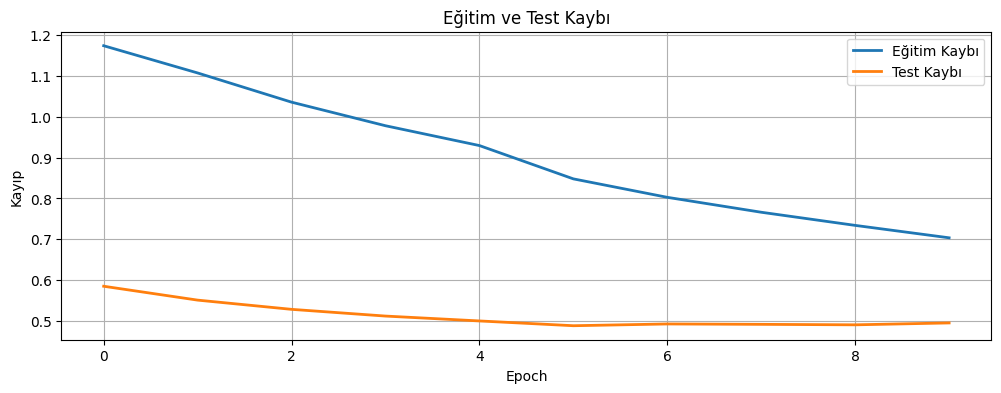

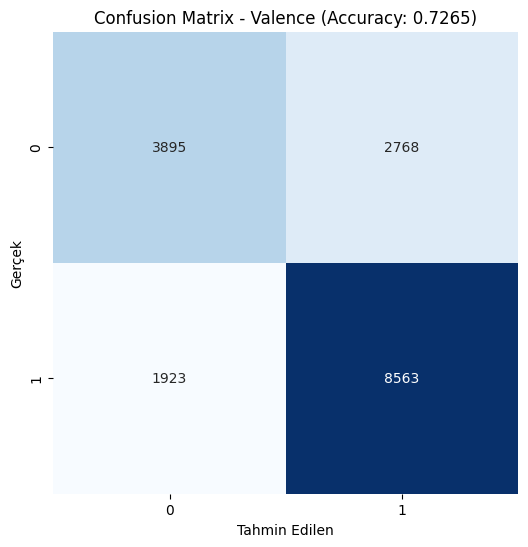

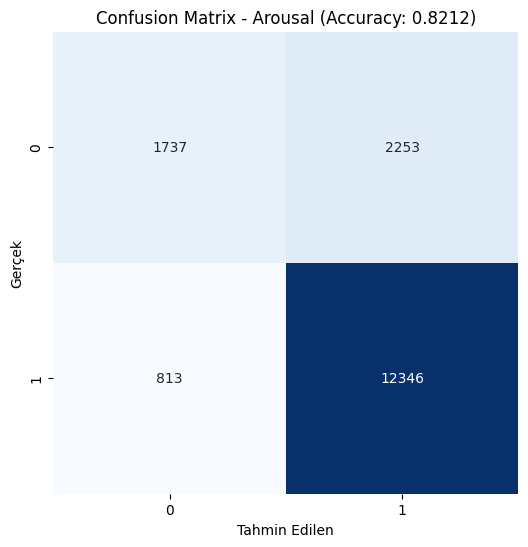

In [20]:
# Sonuçları Test Et ve Raporla
test_loss, valence_acc, arousal_acc, valence_f1, arousal_f1, valence_preds, arousal_preds, all_labels = test_model() # Modified this line
print(f"Final Test Loss: {test_loss:.4f}")
print(f"Final Valence Accuracy: {valence_acc:.4f}, Final Arousal Accuracy: {arousal_acc:.4f}")
print(f"Final Valence F1 Score: {valence_f1:.4f}, Final Arousal F1 Score: {arousal_f1:.4f}")

# Karışıklık Matrisleri
cm_valence = confusion_matrix([l[0] for l in all_labels], valence_preds)
cm_arousal = confusion_matrix([l[1] for l in all_labels], arousal_preds)
print("Confusion Matrix (Valence):\n", cm_valence)
print("Confusion Matrix (Arousal):\n", cm_arousal)

# Görselleştirme Fonksiyonu
def plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc):
    # Eğitim ve Test Kaybı Grafiği
    plt.figure(figsize=(12, 4))
    plt.plot(train_losses, label='Eğitim Kaybı', linewidth=2)
    plt.plot(test_losses, label='Test Kaybı', linewidth=2)
    plt.title('Eğitim ve Test Kaybı')
    plt.xlabel('Epoch')
    plt.ylabel('Kayıp')
    plt.legend()
    plt.grid(True)
    plt.show()

    # Valence Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_valence, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - Valence (Accuracy: {valence_acc:.4f})')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()

    # Arousal Karışıklık Matrisi
    plt.figure(figsize=(6, 6))
    sns.heatmap(cm_arousal, annot=True, fmt='d', cmap='Blues', cbar=False)
    plt.title(f'Confusion Matrix - Arousal (Accuracy: {arousal_acc:.4f})')
    plt.xlabel('Tahmin Edilen')
    plt.ylabel('Gerçek')
    plt.show()

plot_results(train_losses, test_losses, cm_valence, cm_arousal, valence_acc, arousal_acc)